# co

> Covariance and Coherence Matrix Estimation

In [ ]:
#| default_exp cli/co

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import time
from pathlib import Path

import zarr
import numpy as np
import math

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
import moraine.cli as mc
from moraine.cli.logging import mc_logger
from moraine.cli import mk_clean_dir, dask_from_zarr, dask_from_zarr_overlap, dask_to_zarr

In [ ]:
#| export
@mc_logger
def emperical_co_pc(
    rslc:str, # input: rslc stack, shape (nlines, width, nimages)
    is_shp_dir:str, # input: directory for bool array indicating the SHPs of pc
    gix:str, # input: bool array indicating pc, shape (2, n_points)
    coh_dir:str, # output: directory that hold complex coherence matrix for pc
    tnet:str=None, # input: temporal network
    chunks:int=None, # parallel processing azimuth/range chunk size, optional. Default: rslc.chunks[:2]
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''estimate emperical coherence matrix on point cloud data.
    '''
    rslc_path = rslc
    is_shp_dir_path = Path(is_shp_dir)
    gix_path = gix
    coh_dir = Path(coh_dir); mk_clean_dir(coh_dir)
    logger = logging.getLogger(__name__)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."
    nlines, width, nimage = rslc_zarr.shape
    if chunks is None: chunks = rslc_zarr.chunks[:2]

    is_shp0 = sorted(is_shp_dir_path.glob('*.zarr'))[0]
    is_shp0_zarr = zarr.open(is_shp0,'r')
    az_win, r_win = is_shp0_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'''azimuth window size and half azimuth window size: {az_win}, {az_half_win}''')
    logger.info(f'''range window size and half range window size: {r_win}, {r_half_win}''')

    az_chunk, r_chunk = chunks
    n_az_chunk = math.ceil(nlines/az_chunk)
    n_r_chunk = math.ceil(width/r_chunk)
    logger.info(f'parallel processing azimuth chunk size: {az_chunk}')
    logger.info(f'parallel processing range chunk size: {r_chunk}')

    depth = (az_half_win, r_half_win, 0); boundary = {0:'none',1:'none',2:'none'}
    gix_zarr = zarr.open(gix_path,mode='r')
    logger.zarr_info(gix_path, gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    logger.info('loading gix into memory.')
    gix = mc.parallel_read_zarr(gix_zarr,(slice(None),slice(None)))
    logger.info('convert gix to the order of ras chunk')
    chunk_idx, chunk_bounds = mr.pc._pc_split_by_chunk(gix,chunks,(nlines,width))[:2]
    pc_chunksize = tuple(np.diff(chunk_bounds))
    sorted_gix = gix[chunk_idx]
    ras_chunk_order_gix = mr.pc._gix_ras_chunk(sorted_gix,chunk_bounds, chunks, (nlines,width),overlap=(az_half_win,r_half_win))

    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    if tnet is not None:
        tnet = mr.TempNet.load(tnet)
    else:
        tnet = mr.TempNet.from_bandwidth(nimage)
    image_pairs = tnet.image_pairs
    n_image_pairs = image_pairs.shape[0]
    
    logger.info('starting dask cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)
        emperical_co_pc_delayed = delayed(mr.emperical_co_pc,pure=True,nout=1)

        cpu_rslc_overlap = dask_from_zarr_overlap(rslc_path, (*chunks, rslc_zarr.shape[2]), depth)
        logger.darr_info('rslc_overlap', cpu_rslc_overlap)
        cpu_gix_darr = da.from_array(ras_chunk_order_gix,chunks=(pc_chunksize,(2,)))
        logger.darr_info('gix in ras chunk order', cpu_gix_darr)
        if cuda:
            rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
            gix_darr = cpu_gix_darr.map_blocks(cp.asarray)
        else:
            rslc_overlap = cpu_rslc_overlap
            gix_darr = cpu_gix_darr
        rslc_overlap_delayed = rslc_overlap.to_delayed().reshape(-1)
        gix_delayed = gix_darr.to_delayed().reshape(-1)

        logger.info(f'estimating coherence matrix chunk by chunk.')
        futures = []
        for j in range(n_az_chunk*n_r_chunk):
            do_log = j%math.ceil(n_az_chunk*n_r_chunk/10) == 0
            # az_chunk_idx = j//n_az_chunk; r_chunk_idx = j%n_az_chunk
            if pc_chunksize[j] > 0:
                cpu_is_shp = mc.dask_from_zarr(is_shp_dir_path/f'{j}.zarr',chunks=(-1,-1,-1))
                if do_log: logger.darr_info(f'is_shp for chunk {j}',cpu_is_shp)
                if cuda:
                    is_shp = cpu_is_shp.map_blocks(cp.asarray)
                else:
                    is_shp = cpu_is_shp
                is_shp_delayed = is_shp.to_delayed()[0,0,0]
                coh_delayed = emperical_co_pc_delayed(rslc_overlap_delayed[j],gix_delayed[j],is_shp_delayed,image_pairs=image_pairs)
                coh = da.from_delayed(coh_delayed,shape=(pc_chunksize[j],n_image_pairs),meta=xp.array((),dtype=xp.complex64))
                if cuda:
                    cpu_coh = coh.map_blocks(cp.asnumpy)
                else:
                    cpu_coh = coh
                if do_log: logger.darr_info(f'coh for chunk {j}',cpu_coh)
                if do_log: logger.info(f'saving coh for chunk {j}')
                _coh = dask_to_zarr(cpu_coh,coh_dir/f'{j}.zarr',chunks=(coh.shape[0],1),log_zarr=do_log)
                futures.append(_coh)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(futures)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
logger = mc.get_logger()

In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
is_shp = './shp/is_shp.zarr/'
ds_can_is_shp_dir = './co/ds_can_is_shp'
ds_can_key = './co/ds_can_key.zarr'

In [ ]:
mc.ras2pc_ras_chunk(ds_can_gix,is_shp,ds_can_is_shp_dir,ds_can_key,chunks=(1000,1000))

2025-06-16 18:44:00 - log_args - INFO - running function: ras2pc_ras_chunk
2025-06-16 18:44:00 - log_args - INFO - fetching args:
2025-06-16 18:44:00 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-06-16 18:44:00 - log_args - INFO - ras = './shp/is_shp.zarr/'
2025-06-16 18:44:00 - log_args - INFO - pc = './co/ds_can_is_shp'
2025-06-16 18:44:00 - log_args - INFO - key = './co/ds_can_key.zarr'
2025-06-16 18:44:00 - log_args - INFO - chunks = (1000, 1000)
2025-06-16 18:44:00 - log_args - INFO - processes = False
2025-06-16 18:44:00 - log_args - INFO - n_workers = 1
2025-06-16 18:44:00 - log_args - INFO - threads_per_worker = 1
2025-06-16 18:44:00 - log_args - INFO - dask_cluster_arg = {}
2025-06-16 18:44:00 - log_args - INFO - fetching args done.
2025-06-16 18:44:00 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-06-16 18:44:00 - ras2pc_ras_chunk - INFO - loading gix into memory.
2025-06-16 18:44:01 - ras2pc_ras_chunk - I

In [ ]:
rslc = './raw/rslc.zarr'
ds_can_coh_dir = './co/ds_can_coh'

In [ ]:
%%time
emperical_co_pc(rslc,ds_can_is_shp_dir,ds_can_gix,ds_can_coh_dir,chunks=(1000,1000),cuda=False)

2025-06-16 18:44:13 - log_args - INFO - running function: emperical_co_pc
2025-06-16 18:44:13 - log_args - INFO - fetching args:
2025-06-16 18:44:13 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-06-16 18:44:13 - log_args - INFO - is_shp_dir = './co/ds_can_is_shp'
2025-06-16 18:44:13 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-06-16 18:44:13 - log_args - INFO - coh_dir = './co/ds_can_coh'
2025-06-16 18:44:13 - log_args - INFO - tnet = None
2025-06-16 18:44:13 - log_args - INFO - chunks = (1000, 1000)
2025-06-16 18:44:13 - log_args - INFO - cuda = False
2025-06-16 18:44:13 - log_args - INFO - processes = None
2025-06-16 18:44:13 - log_args - INFO - n_workers = None
2025-06-16 18:44:13 - log_args - INFO - threads_per_worker = None
2025-06-16 18:44:13 - log_args - INFO - rmm_pool_size = 0.9
2025-06-16 18:44:13 - log_args - INFO - dask_cluster_arg = {}
2025-06-16 18:44:13 - log_args - INFO - fetching args done.
2025-06-16 18:44:13 - zarr_info - INFO - ./raw/rslc.zarr zarray s

In [ ]:
%%time
if is_cuda_available():
    emperical_co_pc(rslc,ds_can_is_shp_dir,ds_can_gix,ds_can_coh_dir,chunks=(1000,1000),cuda=True)

2025-06-16 18:44:17 - log_args - INFO - running function: emperical_co_pc
2025-06-16 18:44:17 - log_args - INFO - fetching args:
2025-06-16 18:44:17 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-06-16 18:44:17 - log_args - INFO - is_shp_dir = './co/ds_can_is_shp'
2025-06-16 18:44:17 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-06-16 18:44:17 - log_args - INFO - coh_dir = './co/ds_can_coh'
2025-06-16 18:44:17 - log_args - INFO - tnet = None
2025-06-16 18:44:17 - log_args - INFO - chunks = (1000, 1000)
2025-06-16 18:44:17 - log_args - INFO - cuda = True
2025-06-16 18:44:17 - log_args - INFO - processes = None
2025-06-16 18:44:17 - log_args - INFO - n_workers = None
2025-06-16 18:44:17 - log_args - INFO - threads_per_worker = None
2025-06-16 18:44:17 - log_args - INFO - rmm_pool_size = 0.9
2025-06-16 18:44:17 - log_args - INFO - dask_cluster_arg = {}
2025-06-16 18:44:17 - log_args - INFO - fetching args done.
2025-06-16 18:44:18 - zarr_info - INFO - ./raw/rslc.zarr zarray sh

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'

In [ ]:
chunks = zarr.open(ds_can_gix,'r').chunks[0]
mc.pc_concat(ds_can_coh_dir,ds_can_coh,key=ds_can_key,chunks=chunks)

2025-06-16 18:44:28 - log_args - INFO - running function: pc_concat
2025-06-16 18:44:28 - log_args - INFO - fetching args:
2025-06-16 18:44:28 - log_args - INFO - pcs = './co/ds_can_coh'
2025-06-16 18:44:28 - log_args - INFO - pc = './co/ds_can_coh.zarr'
2025-06-16 18:44:28 - log_args - INFO - key = './co/ds_can_key.zarr'
2025-06-16 18:44:28 - log_args - INFO - chunks = 100000
2025-06-16 18:44:28 - log_args - INFO - processes = False
2025-06-16 18:44:28 - log_args - INFO - n_workers = 1
2025-06-16 18:44:28 - log_args - INFO - threads_per_worker = 1
2025-06-16 18:44:28 - log_args - INFO - dask_cluster_arg = {}
2025-06-16 18:44:28 - log_args - INFO - fetching args done.
2025-06-16 18:44:28 - pc_concat - INFO - input pcs: [[Path('co/ds_can_coh/0.zarr'), Path('co/ds_can_coh/1.zarr'), Path('co/ds_can_coh/2.zarr'), Path('co/ds_can_coh/3.zarr'), Path('co/ds_can_coh/4.zarr'), Path('co/ds_can_coh/5.zarr')]]
2025-06-16 18:44:28 - pc_concat - INFO - output pc: ['./co/ds_can_coh.zarr']
2025-06-16 

In [ ]:
ds_can_coh_ave = './co/ds_can_coh_ave.zarr'

In [ ]:
n_point = zarr.open(ds_can_coh,'r').shape[0]
mc.data_reduce(ds_can_coh,ds_can_coh_ave,map_func=np.abs,reduce_func=np.sum,post_map_func=lambda x: x/n_point)

2025-06-16 18:44:33 - log_args - INFO - running function: data_reduce
2025-06-16 18:44:33 - log_args - INFO - fetching args:
2025-06-16 18:44:33 - log_args - INFO - data_in = './co/ds_can_coh.zarr'
2025-06-16 18:44:33 - log_args - INFO - out = './co/ds_can_coh_ave.zarr'
2025-06-16 18:44:33 - log_args - INFO - map_func = <ufunc 'absolute'>
2025-06-16 18:44:33 - log_args - INFO - reduce_func = <function sum>
2025-06-16 18:44:33 - log_args - INFO - axis = 0
2025-06-16 18:44:33 - log_args - INFO - post_map_func = <function <lambda>>
2025-06-16 18:44:33 - log_args - INFO - processes = False
2025-06-16 18:44:33 - log_args - INFO - n_workers = 1
2025-06-16 18:44:33 - log_args - INFO - threads_per_worker = 1
2025-06-16 18:44:33 - log_args - INFO - dask_cluster_arg = {}
2025-06-16 18:44:33 - log_args - INFO - fetching args done.
2025-06-16 18:44:33 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-06-16 18:44:33 - data_reduce - INF

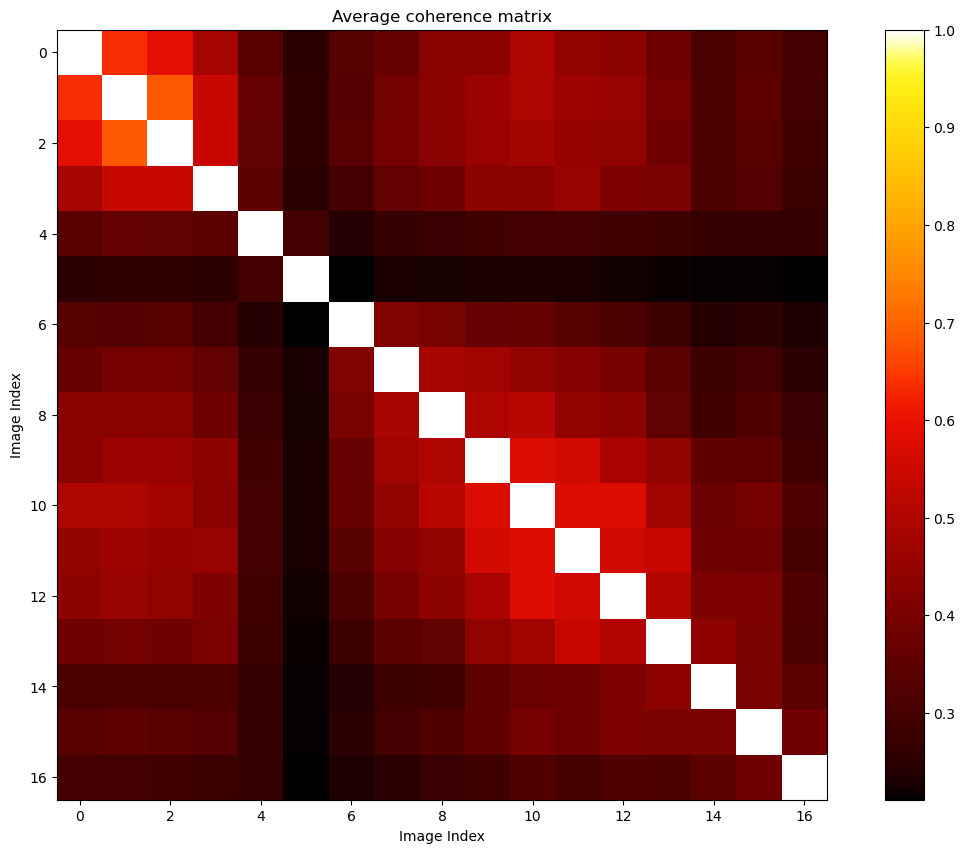

In [ ]:
ds_can_coh_ave_ = mr.uncompress_coh(zarr.open(ds_can_coh_ave,'r')[:])
fig, ax = plt.subplots(1,1,figsize=(15,10))
pcm = ax.imshow(ds_can_coh_ave_,cmap=colorcet.cm.fire)
ax.set(title='Average coherence matrix',xlabel='Image Index',ylabel='Image Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()